<a href="https://colab.research.google.com/github/sinchxn/fake-news-detection/blob/main/fakenews_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [2]:
import pandas as pd
import numpy as np
from nltk.stem import WordNetLemmatizer


import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras import layers as L
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords') # stopwords
nltk.download('punkt') # Tokenizer - to use sent_tokenize, word_tokenize

from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Data

In [4]:
df = pd.read_csv("/content/drive/MyDrive/POM 681 Data/train.csv")

In [5]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [41]:
df['label'].value_counts()


label
1    10413
0    10387
Name: count, dtype: int64

In [6]:
df = df.fillna('')
df["total"] = df['title'] + " " + df["author"]
df.head()

,id,title,author,text,label,total
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Consortiumne...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...


In [7]:
X = df.drop("label", axis = 1)
Y = df["label"]

X.shape, Y.shape

((20800, 5), (20800,))

# Pre-Processing

In [8]:
VOCAB_SIZE = 5000
text = X.copy()

In [9]:
import nltk
nltk.download('wordnet')

def text_cleaning(length):
    lemmatizer = WordNetLemmatizer()
    corpus = []
    for i in range(length):
        m = re.sub("[^a-zA-Z]"," ",text["total"][i])
        m = m.lower()
        m = m.split()
        m = [lemmatizer.lemmatize(word) for word in m if not word in stopwords.words('english')]
        clean_text = " ".join(m)
        corpus.append(clean_text)

    return corpus


[nltk_data] Downloading package wordnet to /root/nltk_data...


In [10]:
%%time
clean_text_corpus = text_cleaning(len(text))

CPU times: user 37.2 s, sys: 4.59 s, total: 41.8 s
Wall time: 42.3 s


In [11]:
clean_text_corpus[0]

'house dem aide even see comey letter jason chaffetz tweeted darrell lucus'

In [12]:
# to one hot
onehot_text = [one_hot(words, VOCAB_SIZE) for words in clean_text_corpus]

In [13]:
# padding sequences
padded_doc = pad_sequences(onehot_text, padding="pre", maxlen = 25)

In [14]:
x = np.array(padded_doc)
y = np.array(Y)

In [15]:
# Train & Test Split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.30, random_state=0)

# Models

##LSTM

In [17]:
def build_model():
    model = tf.keras.Sequential([
        # Embedding layer with pre-trained word embeddings (optional)
        L.Embedding(VOCAB_SIZE, 40, input_length=25),

        # CNN layers
        L.Conv1D(filters=128, kernel_size=3, activation='relu'),
        L.MaxPooling1D(pool_size=2),
        L.Conv1D(filters=256, kernel_size=3, activation='relu'),
        L.MaxPooling1D(pool_size=2),

        # LSTM layer
        L.LSTM(100),

        # Fully connected layers
        L.Dropout(0.7),
        L.Dense(64, activation='relu'),
        L.Dropout(0.7),
        L.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Initialize and compile the model
news_classifier = build_model()
news_classifier.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 25, 40)            200000    
                                                                 
 conv1d_2 (Conv1D)           (None, 23, 128)           15488     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 11, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 9, 256)            98560     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 4, 256)            0         
 g1D)                                                            
                                                                 
 lstm_1 (LSTM)               (None, 100)              

In [18]:
news_classifier = build_model()
news_classifier.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 25, 40)            200000    
                                                                 
 conv1d_4 (Conv1D)           (None, 23, 128)           15488     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 11, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 9, 256)            98560     
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 4, 256)            0         
 g1D)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 100)              

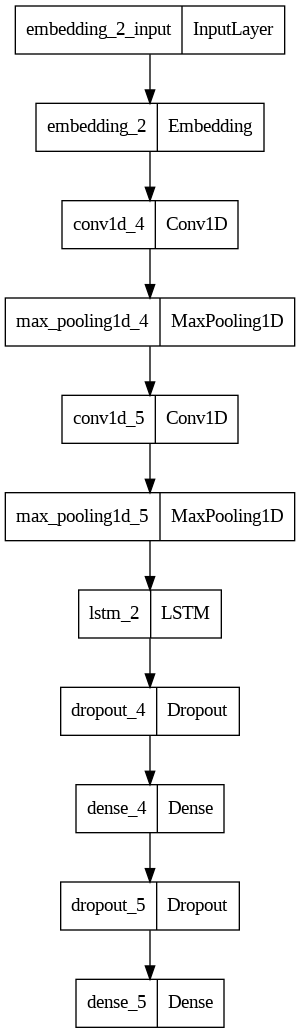

In [19]:
tf.keras.utils.plot_model(news_classifier)

# Training

In [20]:
my_callbacks = [tf.keras.callbacks.ModelCheckpoint("news_classifier.h5", monitor = "val_loss", save_best_only=True),
                tf.keras.callbacks.EarlyStopping(patience=5),
                tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
               ]

In [21]:
history = news_classifier.fit(
    xtrain,
    ytrain,
    epochs = 25,
    batch_size = 128,
    validation_split = 0.2,
    callbacks = my_callbacks
)

Epoch 1/25
91/91 [==============================] - 10s 75ms/step - loss: 0.4997 - accuracy: 0.7304 - val_loss: 0.3008 - val_accuracy: 0.8547 - lr: 0.0010
Epoch 2/25
 1/91 [..............................] - ETA: 7s - loss: 0.2397 - accuracy: 0.9141

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


91/91 [==============================] - 6s 61ms/step - loss: 0.2416 - accuracy: 0.9081 - val_loss: 0.2806 - val_accuracy: 0.8733 - lr: 0.0010
Epoch 3/25
91/91 [==============================] - 5s 57ms/step - loss: 0.1481 - accuracy: 0.9485 - val_loss: 0.3171 - val_accuracy: 0.8716 - lr: 0.0010
Epoch 4/25
91/91 [==============================] - 7s 73ms/step - loss: 0.0942 - accuracy: 0.9724 - val_loss: 0.4137 - val_accuracy: 0.8609 - lr: 0.0010
Epoch 5/25
91/91 [==============================] - 5s 53ms/step - loss: 0.0538 - accuracy: 0.9863 - val_loss: 0.5630 - val_accuracy: 0.8654 - lr: 0.0010
Epoch 6/25
91/91 [==============================] - 6s 65ms/step - loss: 0.0278 - accuracy: 0.9936 - val_loss: 0.7283 - val_accuracy: 0.8630 - lr: 0.0010
Epoch 7/25
91/91 [==============================] - 7s 79ms/step - loss: 0.0204 - accuracy: 0.9950 - val_loss: 0.8391 - val_accuracy: 0.8616 - lr: 0.0010


In [32]:
import tensorflow.keras.callbacks as callbacks

# Learning rate scheduler
lr_scheduler = callbacks.LearningRateScheduler(lambda epoch: 0.001 * 0.9 ** epoch)

my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint("news_classifier.h5", monitor="val_accuracy", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=10, monitor="val_loss"),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001),
    lr_scheduler,
    tf.keras.callbacks.TensorBoard(log_dir="logs/")
]

history = news_classifier.fit(
    xtrain,
    ytrain,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=my_callbacks
)

Epoch 1/50
182/182 [==============================] - 9s 45ms/step - loss: 2.2617e-04 - accuracy: 0.9999 - val_loss: 2.0756 - val_accuracy: 0.8578 - lr: 0.0010
Epoch 2/50
  3/182 [..............................] - ETA: 5s - loss: 1.0538e-04 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


182/182 [==============================] - 8s 43ms/step - loss: 9.1655e-05 - accuracy: 1.0000 - val_loss: 2.2887 - val_accuracy: 0.8575 - lr: 9.0000e-04
Epoch 3/50
182/182 [==============================] - 6s 34ms/step - loss: 1.9039e-04 - accuracy: 1.0000 - val_loss: 2.4080 - val_accuracy: 0.8582 - lr: 8.1000e-04
Epoch 4/50
182/182 [==============================] - 8s 45ms/step - loss: 0.0010 - accuracy: 0.9997 - val_loss: 2.2108 - val_accuracy: 0.8434 - lr: 7.2900e-04
Epoch 5/50
182/182 [==============================] - 6s 35ms/step - loss: 0.0257 - accuracy: 0.9936 - val_loss: 1.1290 - val_accuracy: 0.8609 - lr: 6.5610e-04
Epoch 6/50
182/182 [==============================] - 8s 46ms/step - loss: 0.0114 - accuracy: 0.9968 - val_loss: 1.1523 - val_accuracy: 0.8654 - lr: 5.9049e-04
Epoch 7/50
182/182 [==============================] - 7s 37ms/step - loss: 0.0020 - accuracy: 0.9996 - val_loss: 1.3744 - val_accuracy: 0.8695 - lr: 5.3144e-04
Epoch 8/50
182/182 [=======================

# Prediction

In [28]:
predictions = news_classifier.predict(xtest)
predictions = [int(np.round(pred[0])) for pred in predictions]

195/195 [==============================] - 1s 7ms/step


In [ ]:
predictions

In [30]:
accuracy = accuracy_score(ytest, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8549679487179487


Epoch 1/25
91/91 [==============================] - 7s 72ms/step - loss: 4.5151e-04 - accuracy: 0.9997 - val_loss: 1.7470 - val_accuracy: 0.8547
Epoch 2/25
91/91 [==============================] - 11s 121ms/step - loss: 2.6303e-04 - accuracy: 0.9999 - val_loss: 1.7672 - val_accuracy: 0.8554
Epoch 3/25
91/91 [==============================] - 11s 125ms/step - loss: 2.5116e-04 - accuracy: 0.9999 - val_loss: 1.7875 - val_accuracy: 0.8551
Epoch 4/25
91/91 [==============================] - 7s 72ms/step - loss: 2.1399e-04 - accuracy: 0.9999 - val_loss: 1.8071 - val_accuracy: 0.8551
Epoch 5/25
91/91 [==============================] - 6s 61ms/step - loss: 3.1614e-04 - accuracy: 0.9998 - val_loss: 1.8333 - val_accuracy: 0.8558
Epoch 6/25
91/91 [==============================] - 5s 57ms/step - loss: 2.0129e-04 - accuracy: 1.0000 - val_loss: 1.8627 - val_accuracy: 0.8551


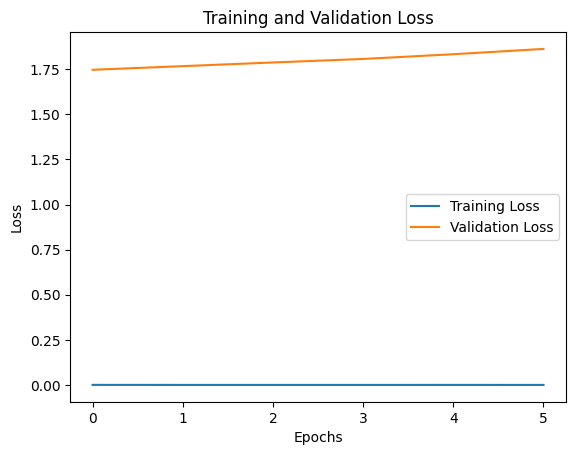

In [31]:
from keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping callback
history = news_classifier.fit(
    xtrain,
    ytrain,
    epochs=25,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Gradient Boosting Model

In [34]:
# Gradient Boosting Model
from sklearn.ensemble import GradientBoostingClassifier

gb_classifier = GradientBoostingClassifier()
gb_classifier.fit(xtrain, ytrain)
y_pred_gb = gb_classifier.predict(xtest)

# Evaluate Gradient Boosting model
accuracy_gb = accuracy_score(ytest, y_pred_gb)
print(f'Gradient Boosting Accuracy: {accuracy_gb}')


Gradient Boosting Accuracy: 0.9102564102564102


In [ ]:
y_pred_train_gb = gb_classifier.predict(xtrain)
accuracy_train_gb = accuracy_score(ytrain, y_pred_train_gb)
print(f'Gradient Boosting Training Accuracy: {accuracy_train_gb}')


Gradient Boosting Training Accuracy: 0.9253434065934066


## Decision Tree Model

In [35]:
# Decision Tree Model
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(xtrain, ytrain)
y_pred_dt = dt_classifier.predict(xtest)

# Evaluate Decision Tree model
accuracy_dt = accuracy_score(ytest, y_pred_dt)
print(f'Decision Tree Accuracy: {accuracy_dt}')


Decision Tree Accuracy: 0.8926282051282052


In [ ]:
y_pred_train_gb = gb_classifier.predict(xtrain)
accuracy_train_gb = accuracy_score(ytrain, y_pred_train_gb)
print(f'Decision Training Accuracy: {accuracy_train_gb}')


Decision Training Accuracy: 0.9253434065934066


## Random Forest Model

In [36]:
# Random Forest Model
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier()
rf_classifier.fit(xtrain, ytrain)
y_pred_rf = rf_classifier.predict(xtest)

# Evaluate Random Forest model
accuracy_rf = accuracy_score(ytest, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf}')


Random Forest Accuracy: 0.9030448717948718


In [ ]:
y_pred_train_gb = gb_classifier.predict(xtrain)
accuracy_train_gb = accuracy_score(ytrain, y_pred_train_gb)
print(f'Random Forest Training Accuracy: {accuracy_train_gb}')


Random Forest Training Accuracy: 0.9253434065934066


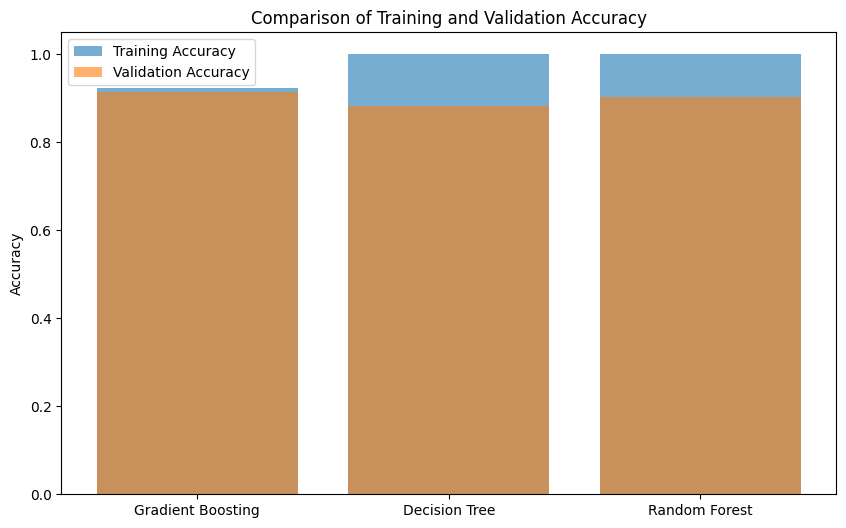

In [40]:
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import accuracy_score

# Assuming `xtrain`, `ytrain`, `xtest`, and `ytest` contain your data

# Initialize the models
gb_classifier = GradientBoostingClassifier(random_state=42, n_estimators=100)
dt_classifier = DecisionTreeClassifier(random_state=42)
rf_classifier = RandomForestClassifier(random_state=42, n_estimators=100)

# Perform cross-validation for each model
cv_gb = cross_validate(gb_classifier, xtrain, ytrain, cv=5, return_train_score=True)
cv_dt = cross_validate(dt_classifier, xtrain, ytrain, cv=5, return_train_score=True)
cv_rf = cross_validate(rf_classifier, xtrain, ytrain, cv=5, return_train_score=True)

# Calculate mean train and validation accuracies
mean_train_gb = cv_gb['train_score'].mean()
mean_val_gb = cv_gb['test_score'].mean()

mean_train_dt = cv_dt['train_score'].mean()
mean_val_dt = cv_dt['test_score'].mean()

mean_train_rf = cv_rf['train_score'].mean()
mean_val_rf = cv_rf['test_score'].mean()

# Plot training and validation accuracies for each model
models = ['Gradient Boosting', 'Decision Tree', 'Random Forest']
train_accuracies = [mean_train_gb, mean_train_dt, mean_train_rf]
val_accuracies = [mean_val_gb, mean_val_dt, mean_val_rf]

plt.figure(figsize=(10, 6))
plt.bar(models, train_accuracies, alpha=0.6, label='Training Accuracy')
plt.bar(models, val_accuracies, alpha=0.6, label='Validation Accuracy')

# Add labels and title
plt.ylabel('Accuracy')
plt.title('Comparison of Training and Validation Accuracy')
plt.legend()

# Show the plot
plt.show()


# Visualisation

In [ ]:
# Importing necessary libraries
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, model_name):
    plt.figure(figsize=(4, 4))
    sns.set(font_scale=0.8)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=.5, square=True,
                xticklabels=classes, yticklabels=classes, cbar_kws={"shrink": 0.8})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('True', fontsize=14)
    plt.show()

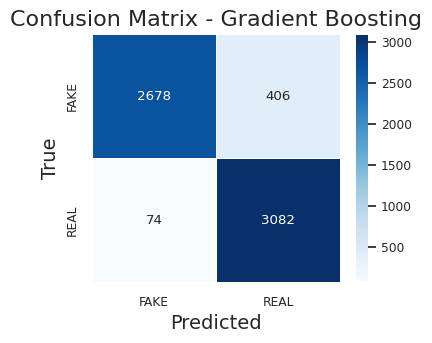

In [ ]:
# Confusion Matrix for Gradient Boosting
cm_gb = confusion_matrix(ytest, y_pred_gb)
plot_confusion_matrix(cm_gb, classes=['FAKE', 'REAL'], model_name='Gradient Boosting')


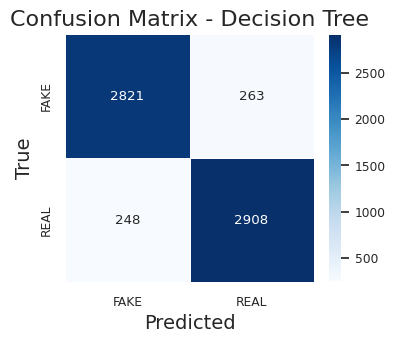

In [ ]:

# Confusion Matrix for Decision Tree
cm_dt = confusion_matrix(ytest, y_pred_dt)
plot_confusion_matrix(cm_dt, classes=['FAKE', 'REAL'], model_name='Decision Tree')



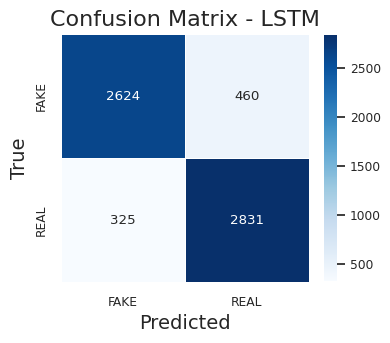

In [ ]:
# Confusion Matrix for LSTM
cm_lstm = confusion_matrix(ytest, predictions)
plot_confusion_matrix(cm_lstm, classes=['FAKE', 'REAL'], model_name='LSTM')



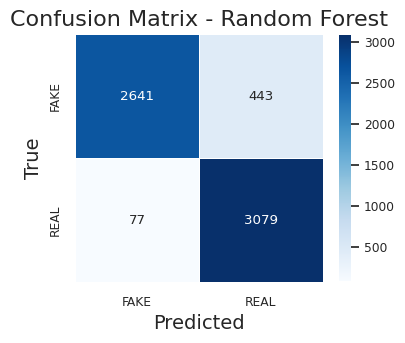

In [ ]:
# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(ytest, y_pred_rf)
plot_confusion_matrix(cm_rf, classes=['FAKE', 'REAL'], model_name='Random Forest')

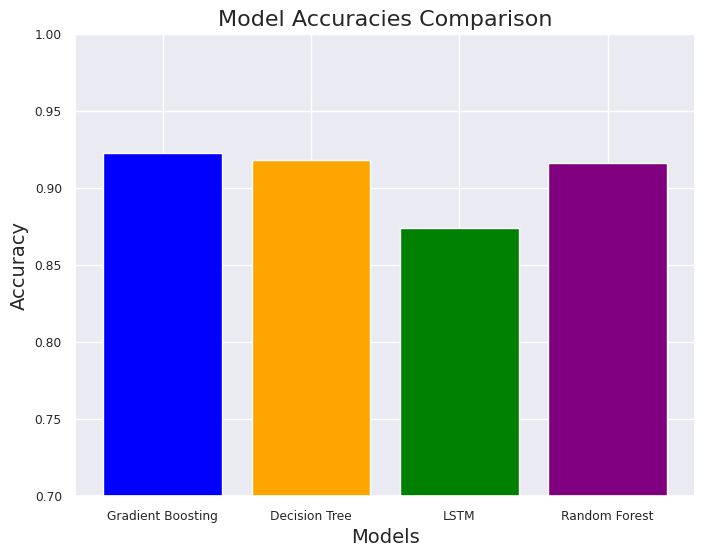

In [ ]:
# Importing necessary libraries
import matplotlib.pyplot as plt

# Model names and corresponding accuracies
model_names = [ 'Gradient Boosting', 'Decision Tree', 'LSTM', 'Random Forest']
accuracies = [accuracy_gb, accuracy_dt, accuracy, accuracy_rf]

# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracies, color=['blue', 'orange', 'green', 'purple', 'brown'])
plt.xlabel('Models', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Model Accuracies Comparison', fontsize=16)
plt.ylim(0.70, 1.0)  # Adjust the y-axis limits if needed
plt.show()


In [ ]:


# Model names and corresponding accuracies
model_names = [ 'Gradient Boosting', 'Decision Tree', 'LSTM', 'Random Forest']
accuracies = [accuracy_gb, accuracy_dt, accuracy, accuracy_rf]

# Print the accuracies
for i in range(len(model_names)):
  print(f"{model_names[i]} Accuracy: {accuracies[i]}")


Gradient Boosting Accuracy: 0.9230769230769231
Decision Tree Accuracy: 0.9181089743589743
LSTM Accuracy: 0.874198717948718
Random Forest Accuracy: 0.9166666666666666
